In [1]:
# CELL 1 — Imports and global settings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [2]:
# CELL 2 — Load dataset and inspect columns

CSV_PATH = "selected_data (5).csv"   # <-- CHANGE IF NEEDED
df = pd.read_csv(CSV_PATH)

print("Dataset shape:", df.shape)
print("\nColumns in dataframe:")
for i, c in enumerate(df.columns):
    print(f"{i:2d}: {repr(c)}")


Dataset shape: (201828, 39)

Columns in dataframe:
 0: 'Flow Duration'
 1: 'Fwd Packet Length Max'
 2: 'Fwd Packet Length Min'
 3: 'Fwd Packet Length Mean'
 4: 'Fwd Packet Length Std'
 5: 'Bwd Packet Length Max'
 6: 'Bwd Packet Length Min'
 7: 'Bwd Packet Length Mean'
 8: 'Bwd Packet Length Std'
 9: 'Flow IAT Mean'
10: 'Flow IAT Std'
11: 'Flow IAT Max'
12: 'Fwd IAT Total'
13: 'Fwd IAT Mean'
14: 'Fwd IAT Std'
15: 'Fwd IAT Max'
16: 'Fwd IAT Min'
17: 'Bwd IAT Total'
18: 'Bwd IAT Mean'
19: 'Bwd IAT Std'
20: 'Bwd IAT Max'
21: 'Bwd IAT Min'
22: 'Fwd PSH Flags'
23: 'Min Packet Length'
24: 'Max Packet Length'
25: 'Packet Length Mean'
26: 'Packet Length Variance'
27: 'Down/Up Ratio'
28: 'Average Packet Size'
29: 'Subflow Fwd Packets'
30: 'Active Mean'
31: 'Active Std'
32: 'Active Max'
33: 'Active Min'
34: 'Idle Mean'
35: 'Idle Std'
36: 'Idle Max'
37: 'Idle Min'
38: 'is_benign'


In [3]:
# CELL 3 — Set the correct label column and convert to integers

# Clean column names
df.columns = df.columns.str.strip()

# TODO: CHANGE THIS to your actual label column name from Cell 2 output
LABEL_COL = "is_benign"   # <-- EDIT HERE

print(f"Using label column: {LABEL_COL}")

# Extract raw labels
y_raw = df[LABEL_COL]

def map_to_binary(y_series: pd.Series) -> pd.Series:
    """Map any label column to 0/1 integers."""
    # Case 1: numeric labels
    if np.issubdtype(y_series.dtype, np.number):
        uniq = sorted(pd.unique(y_series.dropna()))
        print("Numeric labels found:", uniq)
        mapping = {old: i for i, old in enumerate(uniq)}
        print("Mapping to:", mapping)
        return y_series.map(mapping).astype(int)

    # Case 2: string labels
    y_lower = y_series.astype(str).str.lower().str.strip()
    uniq = sorted(pd.unique(y_lower.dropna()))
    print("String labels found:", uniq)

    if set(uniq) <= {"benign", "malware"}:
        mapping = {"benign": 0, "malware": 1}
        print("Using mapping:", mapping)
        return y_lower.map(mapping).astype(int)

    if set(uniq) <= {"0", "1"}:
        mapping = {"0": 0, "1": 1}
        print("Using mapping:", mapping)
        return y_lower.map(mapping).astype(int)

    # Fallback mapping
    mapping = {label: i for i, label in enumerate(uniq)}
    print("⚠️ Fallback mapping:", mapping)
    return y_lower.map(mapping).astype(int)

# Apply mapping
y = map_to_binary(y_raw)
df[LABEL_COL] = y

print("\nLabel counts before flipping:")
print(df[LABEL_COL].value_counts())


Using label column: is_benign
Numeric labels found: [np.int64(0), np.int64(1)]
Mapping to: {np.int64(0): 0, np.int64(1): 1}

Label counts before flipping:
is_benign
0    188328
1     13500
Name: count, dtype: int64


In [4]:
# CELL 4 — Flip labels because dataset was reversed

print("Before flipping:")
print(df[LABEL_COL].value_counts())

# Flip: 0 → 1 and 1 → 0
df[LABEL_COL] = 1 - df[LABEL_COL]

print("\nAfter flipping:")
print(df[LABEL_COL].value_counts())


Before flipping:
is_benign
0    188328
1     13500
Name: count, dtype: int64

After flipping:
is_benign
1    188328
0     13500
Name: count, dtype: int64


In [5]:
# CELL 5 — Separate BENIGN and MALWARE subsets

df_benign = df[df[LABEL_COL] == 0].copy()   # BENIGN
df_malware = df[df[LABEL_COL] == 1].copy()  # MALWARE

print("BENIGN rows (label 0):", len(df_benign))
print("MALWARE rows (label 1):", len(df_malware))


BENIGN rows (label 0): 13500
MALWARE rows (label 1): 188328


In [6]:
# CELL 6 — Create datasets with specific ratios

def create_ratio_dataset(n_benign: int, n_malware: int, random_state=RANDOM_STATE):
    """Return (X, y) for a dataset with given BENIGN:MALWARE counts."""
    
    available_ben = len(df_benign)
    available_mal = len(df_malware)

    n_ben = min(available_ben, n_benign)
    n_mal = min(available_mal, n_malware)

    ben_sample = df_benign.sample(n=n_ben, random_state=random_state)
    mal_sample = df_malware.sample(n=n_mal, random_state=random_state)

    combined = pd.concat([ben_sample, mal_sample], axis=0)
    combined = combined.sample(frac=1, random_state=random_state).reset_index(drop=True)

    y_combined = combined[LABEL_COL].to_numpy()
    X_combined = combined.drop(columns=[LABEL_COL])

    X_num = X_combined.select_dtypes(include=[np.number]).fillna(0).copy()

    return X_num, y_combined


In [7]:
# CELL 7 — Train SVM and print all metrics

def train_svm_and_evaluate(X, y, ratio_label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=RANDOM_STATE
    )

    svm_model = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            probability=True,
            random_state=RANDOM_STATE
        ))
    ])

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec  = recall_score(y_test, y_pred, pos_label=1)
    f1   = f1_score(y_test, y_pred, pos_label=1)
    roc  = roc_auc_score(y_test, y_proba)
    cm   = confusion_matrix(y_test, y_pred)

    print("\n===============================================")
    print("RESULTS FOR:", ratio_label)
    print("===============================================")
    print("Accuracy  :", acc)
    print("Precision :", prec)
    print("Recall    :", rec)
    print("F1-score  :", f1)
    print("ROC-AUC   :", roc)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n",
          classification_report(y_test, y_pred,
                                target_names=["BENIGN (0)", "MALWARE (1)"]))

    return {
        "ratio": ratio_label,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    }


In [8]:
# CELL 8 — Evaluate SVM on ORIGINAL dataset

X_full = df.drop(columns=[LABEL_COL]).select_dtypes(include=[np.number]).fillna(0)
y_full = df[LABEL_COL].to_numpy()

orig_ben = int((y_full == 0).sum())
orig_mal = int((y_full == 1).sum())

orig_label = f"ORIGINAL ({orig_ben} BENIGN : {orig_mal} MALWARE)"

print("Evaluating original dataset...")

all_results = []
ratio_labels = []
accuracy_values = []

metrics_orig = train_svm_and_evaluate(X_full, y_full, orig_label)

all_results.append(metrics_orig)
ratio_labels.append(orig_label)
accuracy_values.append(metrics_orig["accuracy"])


Evaluating original dataset...

RESULTS FOR: ORIGINAL (13500 BENIGN : 188328 MALWARE)
Accuracy  : 0.9430709012535302
Precision : 0.9585148309479361
Recall    : 0.9814686985610365
F1-score  : 0.9698559697772647
ROC-AUC   : 0.9469086178516432

Confusion Matrix:
 [[ 1100  1600]
 [  698 36968]]

Classification Report:
               precision    recall  f1-score   support

  BENIGN (0)       0.61      0.41      0.49      2700
 MALWARE (1)       0.96      0.98      0.97     37666

    accuracy                           0.94     40366
   macro avg       0.79      0.69      0.73     40366
weighted avg       0.94      0.94      0.94     40366



In [9]:
# Cell 8 — Build datasets for each artificial ratio, train SVM, and collect accuracies

ratio_specs = [
    (10000, 90000, "10k BENIGN : 90k MALWARE"),
    (15000, 85000, "15k BENIGN : 85k MALWARE"),
    (20000, 80000, "20k BENIGN : 80k MALWARE"),
    (25000, 75000, "25k BENIGN : 75k MALWARE"),
    (30000, 70000, "30k BENIGN : 70k MALWARE"),
    (35000, 65000, "35k BENIGN : 65k MALWARE"),
    (40000, 60000, "40k BENIGN : 60k MALWARE"),
    (45000, 55000, "45k BENIGN : 55k MALWARE"),
    (50000, 50000, "50k BENIGN : 50k MALWARE"),
]

for n_ben, n_mal, label in ratio_specs:
    print(f"\n>>> Building dataset for {label}")
    X_ratio, y_ratio = create_ratio_dataset(n_ben, n_mal)
    print("Shape of X_ratio:", X_ratio.shape, "| Shape of y_ratio:", y_ratio.shape)

    metrics = train_svm_and_evaluate(X_ratio, y_ratio, label)

    all_results.append(metrics)
    ratio_labels.append(label)
    accuracy_values.append(metrics["accuracy"])



>>> Building dataset for 10k BENIGN : 90k MALWARE
Shape of X_ratio: (100000, 38) | Shape of y_ratio: (100000,)

RESULTS FOR: 10k BENIGN : 90k MALWARE
Accuracy  : 0.92975
Precision : 0.9635733839879322
Recall    : 0.9581666666666667
F1-score  : 0.9608624195660046
ROC-AUC   : 0.9606247777777778

Confusion Matrix:
 [[ 1348   652]
 [  753 17247]]

Classification Report:
               precision    recall  f1-score   support

  BENIGN (0)       0.64      0.67      0.66      2000
 MALWARE (1)       0.96      0.96      0.96     18000

    accuracy                           0.93     20000
   macro avg       0.80      0.82      0.81     20000
weighted avg       0.93      0.93      0.93     20000


>>> Building dataset for 15k BENIGN : 85k MALWARE
Shape of X_ratio: (98500, 38) | Shape of y_ratio: (98500,)

RESULTS FOR: 15k BENIGN : 85k MALWARE
Accuracy  : 0.9260913705583756
Precision : 0.9679108970499699
Recall    : 0.9457058823529412
F1-score  : 0.9566795596548646
ROC-AUC   : 0.965639694989106

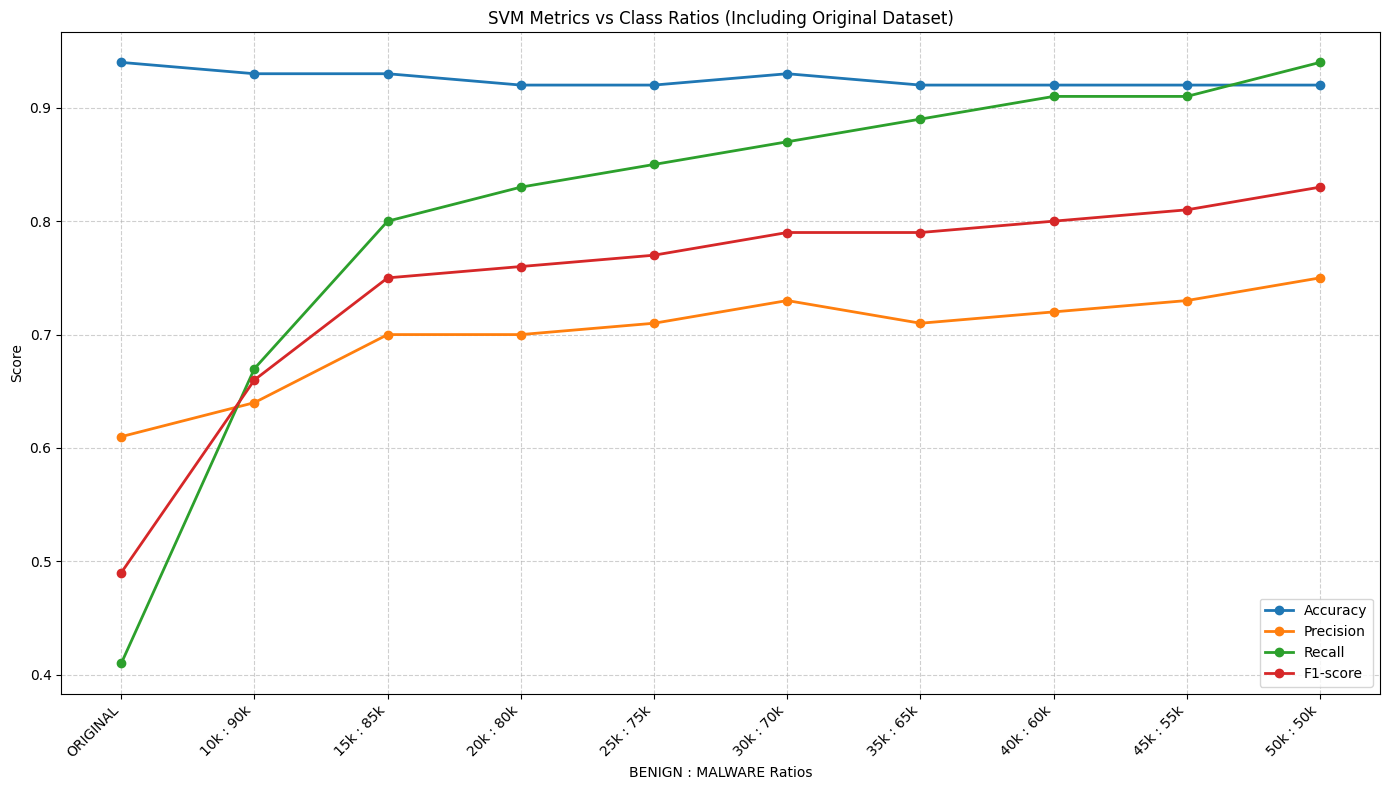

In [9]:
# CELL 10 — Plot all metrics vs class ratios

import matplotlib.pyplot as plt  # <-- YOU MISSED THIS

# Build metric lists from all_results (must be in the same order as ratio_labels)

ratio_labels     = ['ORIGINAL', '10k : 90k','15k : 85k', '20k : 80k', '25k : 75k', '30k : 70k', '35k : 65k', '40k : 60k', '45k : 55k', '50k : 50k'] 
accuracy_values  = [0.94, 0.93, 0.93, 0.92, 0.92, 0.93, 0.92, 0.92, 0.92, 0.92]
precision_values = [0.61, 0.64, 0.70, 0.70, 0.71, 0.73, 0.71, 0.72, 0.73, 0.75]
recall_values    = [0.41, 0.67, 0.80, 0.83, 0.85, 0.87, 0.89, 0.91, 0.91, 0.94]
f1_values        = [0.49, 0.66, 0.75, 0.76, 0.77, 0.79, 0.79, 0.80, 0.81, 0.83,]

plt.figure(figsize=(14,8))

plt.plot(ratio_labels, accuracy_values,  marker="o", linewidth=2, label="Accuracy")
plt.plot(ratio_labels, precision_values, marker="o", linewidth=2, label="Precision")
plt.plot(ratio_labels, recall_values,    marker="o", linewidth=2, label="Recall")
plt.plot(ratio_labels, f1_values,        marker="o", linewidth=2, label="F1-score")


plt.title("SVM Metrics vs Class Ratios (Including Original Dataset)")
plt.xlabel("BENIGN : MALWARE Ratios")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
